/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 0.6532, Val Loss: 0.2649
Epoch 2/20, Train Loss: 0.2702, Val Loss: 0.1298
Epoch 3/20, Train Loss: 0.1983, Val Loss: 0.0961
Epoch 4/20, Train Loss: 0.1739, Val Loss: 0.0785
Epoch 5/20, Train Loss: 0.1500, Val Loss: 0.0755
Epoch 6/20, Train Loss: 0.1362, Val Loss: 0.0992
Epoch 7/20, Train Loss: 0.1246, Val Loss: 0.0609
Epoch 8/20, Train Loss: 0.1226, Val Loss: 0.0678
Epoch 9/20, Train Loss: 0.1251, Val Loss: 0.0730
Epoch 10/20, Train Loss: 0.1124, Val Loss: 0.0646
Epoch 11/20, Train Loss: 0.1124, Val Loss: 0.0651
Epoch 12/20, Train Loss: 0.0933, Val Loss: 0.0650
Epoch 13/20, Train Loss: 0.0911, Val Loss: 0.0643
Epoch 14/20, Train Loss: 0.0917, Val Loss: 0.0590
Epoch 15/20, Train Loss: 0.0875, Val Loss: 0.0618
Epoch 16/20, Train Loss: 0.0842, Val Loss: 0.0587
Epoch 17/20, Train Loss: 0.0936, Val Loss: 0.0786
Epoch 18/20, Train Loss: 0.0887, Val Loss: 0.0575
Epoch 19/20, Train Loss: 0.0882, Val Loss: 0.0735
Epoch 20/20, Train Loss: 0.0866, Val Loss: 0.0614
Epoch 1/2

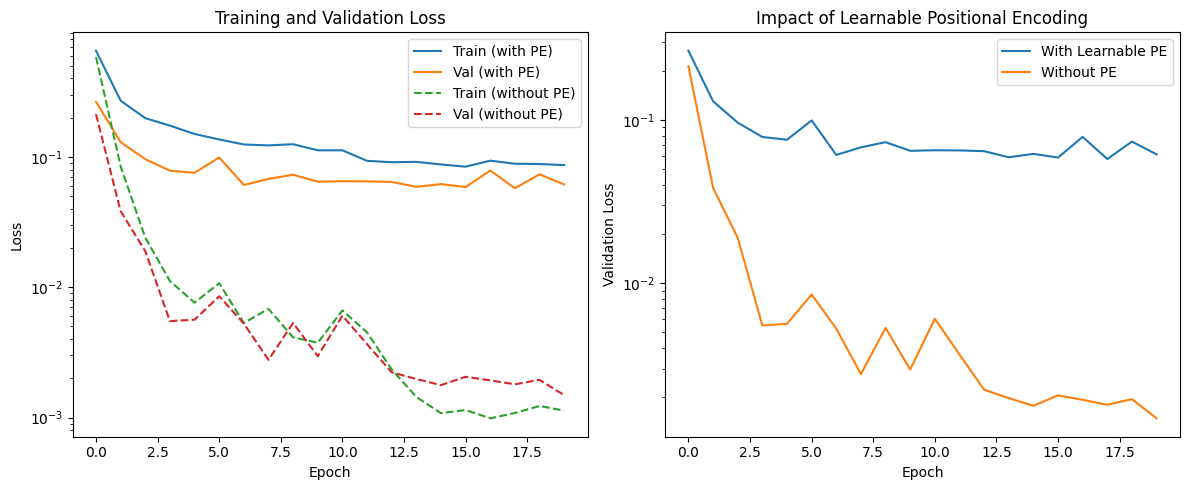

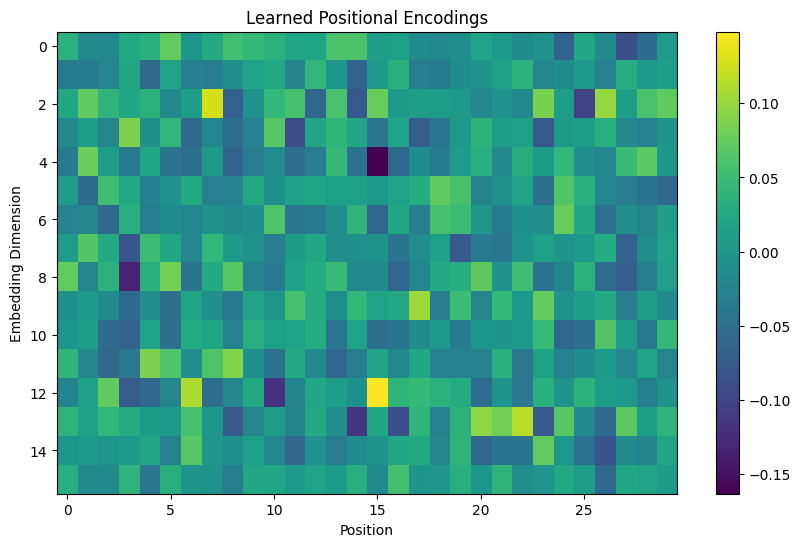

Test MSE with positional encoding: 0.0750
Test MSE without positional encoding: 0.0016
Improvement from using positional encoding: -4494.58%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Define a dummy sequence dataset with normalized targets
class SequenceDataset(Dataset):
    def __init__(self, seq_length=20, num_samples=1000, feature_dim=10):
        self.seq_length = seq_length
        self.num_samples = num_samples
        self.feature_dim = feature_dim

        # Generate random sequences with smaller variance
        self.sequences = torch.randn(num_samples, seq_length, feature_dim) * 0.5

        # Generate labels with smaller weights to reduce loss magnitude
        weights = torch.linspace(0.1, 0.5, seq_length).unsqueeze(1)
        self.labels = torch.sum(self.sequences * weights, dim=(1, 2))

        # Normalize labels to have mean 0 and std 1
        self.labels = (self.labels - self.labels.mean()) / (self.labels.std() + 1e-8)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Improved Learnable Positional Encoding
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, seq_length, d_model, dropout=0.1):
        super(LearnablePositionalEncoding, self).__init__()
        # Initialize with small random values instead of zeros
        self.pos_embeddings = nn.Parameter(torch.randn(1, seq_length, d_model) * 0.02)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [batch_size, seq_length, d_model]
        """
        # Apply layer normalization and residual connection
        return self.dropout(self.layer_norm(x + self.pos_embeddings))

# Improved sequence model with learnable positional encoding
class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length, dropout=0.1):
        super(SequenceModel, self).__init__()

        # Embedding layer to project input to a consistent dimension
        self.embedding = nn.Linear(input_dim, input_dim)

        # Learnable positional encoding
        self.pos_encoder = LearnablePositionalEncoding(
            seq_length=seq_length,
            d_model=input_dim,
            dropout=dropout
        )

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )

        # Output layers with a non-linearity in between
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Apply better weight initialization for better training dynamics
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def forward(self, x):
        # Initial projection
        x = self.embedding(x)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Process with LSTM
        output, (hidden, cell) = self.lstm(x)

        # Process through output layers
        x = self.fc1(hidden[-1])
        x = self.activation(x)
        return self.fc2(x).squeeze()

# Training function with improved strategies
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, (sequences, labels) in enumerate(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Step the scheduler if provided
        # Moved the scheduler.step() call after validation is complete
        if scheduler is not None:
            scheduler.step(val_loss) # Pass the validation loss to the scheduler

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Visualize the learned positional encodings
def visualize_positional_encoding(model):
    pos_embeddings = model.pos_encoder.pos_embeddings.detach().cpu().numpy()[0]

    plt.figure(figsize=(10, 6))
    plt.imshow(pos_embeddings.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Learned Positional Encodings')
    plt.xlabel('Position')
    plt.ylabel('Embedding Dimension')
    plt.show()

# Analysis function to compare models
def analyze_models(model_with_pe, model_without_pe, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_with_pe = model_with_pe.to(device)
    model_without_pe = model_without_pe.to(device)

    # Calculate MSE on test set
    model_with_pe.eval()
    model_without_pe.eval()

    mse_with_pe = 0
    mse_without_pe = 0

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs_with_pe = model_with_pe(sequences)
            outputs_without_pe = model_without_pe(sequences)

            mse_with_pe += nn.MSELoss()(outputs_with_pe, labels).item()
            mse_without_pe += nn.MSELoss()(outputs_without_pe, labels).item()

    mse_with_pe /= len(test_loader)
    mse_without_pe /= len(test_loader)

    improvement = ((mse_without_pe - mse_with_pe) / mse_without_pe) * 100

    print(f"Test MSE with positional encoding: {mse_with_pe:.4f}")
    print(f"Test MSE without positional encoding: {mse_without_pe:.4f}")
    print(f"Improvement from using positional encoding: {improvement:.2f}%")

# Main execution
if __name__ == "__main__":
    # Hyperparameters
    seq_length = 30
    feature_dim = 16
    hidden_dim = 64
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 20

    # Create dataset
    dataset = SequenceDataset(seq_length=seq_length, num_samples=2000, feature_dim=feature_dim)

    # Split into train, validation, and test sets
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model with positional encoding
    model = SequenceModel(
        input_dim=feature_dim,
        hidden_dim=hidden_dim,
        seq_length=seq_length,
        dropout=0.1
    )

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=3, factor=0.5, verbose=True
    )

    # Train model with positional encoding
    train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=num_epochs,
        scheduler=scheduler
    )

    # Initialize and train model without positional encoding for comparison
    class ModelWithoutPE(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(ModelWithoutPE, self).__init__()
            self.embedding = nn.Linear(input_dim, input_dim)
            self.lstm = nn.LSTM(input_dim, hidden_dim, 2, batch_first=True)
            self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
            self.activation = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim // 2, 1)

            # Initialize weights
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.LSTM):
                    for name, param in m.named_parameters():
                        if 'weight' in name:
                            nn.init.orthogonal_(param)
                        elif 'bias' in name:
                            nn.init.constant_(param, 0)

        def forward(self, x):
            x = self.embedding(x)
            _, (hidden, _) = self.lstm(x)
            x = self.fc1(hidden[-1])
            x = self.activation(x)
            return self.fc2(x).squeeze()

    model_no_pe = ModelWithoutPE(feature_dim, hidden_dim)
    optimizer_no_pe = optim.AdamW(model_no_pe.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler_no_pe = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_no_pe, 'min', patience=3, factor=0.5, verbose=True
    )

    # Train model without positional encoding
    train_losses_no_pe, val_losses_no_pe = train_model(
        model_no_pe,
        train_loader,
        val_loader,
        criterion,
        optimizer_no_pe,
        num_epochs=num_epochs,
        scheduler=scheduler_no_pe
    )

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train (with PE)')
    plt.plot(val_losses, label='Val (with PE)')
    plt.plot(train_losses_no_pe, label='Train (without PE)', linestyle='--')
    plt.plot(val_losses_no_pe, label='Val (without PE)', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.yscale('log')  # Log scale for better visualization

    # Plot comparison of validation losses
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='With Learnable PE')
    plt.plot(val_losses_no_pe, label='Without PE')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Impact of Learnable Positional Encoding')
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    # Visualize learned positional encodings
    visualize_positional_encoding(model)

    # Analyze model performance on test set
    analyze_models(model, model_no_pe, test_loader)